# TP noté :  Discrétisation de l'équation de la chaleur par le schéma de Crank-Nicolson

In [1]:
import numpy as np
import math

import scipy.sparse as sparse
import scipy.sparse.linalg

from scipy.integrate import quad

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

### Equation de la chaleur :
On se place dans le domaine temporel $]0,T[$ ($T>0$) et spatial $]0,1[$.
On souhaite discrétiser l'équation de la chaleur avec des conditions aux limites de Dirichlet homogènes :
$$\dfrac{\partial u}{\partial t} - \dfrac{\partial^2 u}{\partial x^2} = f \text{ dans } ]0,T[ \times ]0,1[,$$
$$u(t,0) = u(t,1) = 0 \text{ pour } t \in ]0,T[,$$
$$u(0,x) = u_0(x) \text{ pour } x \in ]0,1[,$$
où $f$ est une fonction de $]0,T[ \times ]0,1[$ donnée et $u_0$ est une fonction donnée de $]0,1[$.

### Discrétisation du domaine :
On discrétise le domaine spatial $]X_{\text{min}},X_{\text{max}}[$ par $M>0$ sous-intervalles (dans la suite $X_{\text{min}}=0$ et $X_{\text{max}}=1$). 
Les points correspondant à cette discrétisation sont les $x_i = X_{\text{min}} + i h_x$ avec $h_x = \frac{X_{\text{max}} - X_{\text{min}}}{M}$ ($0 \leq i \leq M$). 
On discrétise le domaine temporel $]0,T[$ par $N>0$ sous-intervalles.
Les points correspondants sont les $t_n = n h_t$ avec $h_t = \frac{T}{N}$.
On pourra calculer ces points avec les commandes suivantes :

In [2]:
M=2
print(np.linspace(0,1,M+1))

T=2
N=2
print(np.linspace(0,T,N+1))

[0.  0.5 1. ]
[0. 1. 2.]


### Solution exacte :

Pour étudier la convergence de nos schémas numériques, on propose la solution suivante :
$$u(t,x) = \cos(t)\sin(\pi x) . $$

La fonction second membre correspondante est
$$f(t,x) = (\pi^2 \cos(t)-\sin(t)) \sin(\pi x) ,$$
et la donnée initiale est
$$ u_0(x) = \sin(\pi x) . $$

In [98]:
M_PI = math.pi

# sol exacte
def u_ex(t,x):
    return math.cos(t)*math.sin(M_PI * x)
    
# fonction second membre
def f(t,x):
    return (M_PI**2 * math.cos(t) - math.sin(t)) * math.sin(M_PI * x)

# donnée initiale
def u_0(x):
    return math.sin(M_PI*x)


### Schéma de Crank-Nicolson centré :
Le schéma de Crank-Nicolson pour la discrétisation de l'équation différentielle ordinaire $u'(t) = g(t,u(t))$ correspond à
$$
u_{n+1} = u_n + \frac{h_t}2 \Big( g(t_n , u_n) + g(t_{n+1}, u_{n+1}) \Big) .
$$
Nous allons appliquer ce schéma à l'équation de la chaleur pour discrétiser la dérivée en temps.
La dérivée seconde en espace a déjà été discrétisée pour la différence centrée
$$
\partial_{xx}^2 u(t,x_j) \simeq \frac{u(t,x_{j+1}) - 2 u(t,x_j) + u(t,x_{j-1})}{h_x^2} .
$$
Ceci nous donne le schéma aux différences finies suivant :
$$ \left\{ \begin{array}{l}
 u_{j}^{n+1} = u_j^n + \dfrac{h_t}{2 h_x^2} \Big((u_{j-1}^{n+1} - 2 u_j^{n+1} + u_{j+1}^{n+1} + u_{j-1}^n - 2 u_j^n + u_{j+1}^n \Big) + \frac{h_t}2 \Big(f(t_{n+1},x_j) + f(t_n,x_j) \Big) 
 \text{  pour  } 1 \leq j \leq M-1 \text{  et  } 0 \leq n \leq N-1 ,
 \\
 u_0^n = u_M^n = 0 \text{  pour  } 0 \leq n \leq N ,
 \\
 u_j^0 = u_0(x_j) \text{  pour  } 0 \leq j \leq M .
 \end{array} \right.$$

### Système matriciel

Ce schéma est implicite : des indices n+1 sont présents à la fois à gauche et à droite de l'équation. A chaque pas de temps, il va donc falloir résoudre un système linéaire pour calculer la solution approchée au pas de temps suivant. Etablissons le système linéaire à résoudre.

On pose 
$$
U^n = \left(
\begin{array}{c}
u_1^n \\ u_2^n \\ \vdots \\ u_{M-1}^n
\end{array}
\right)
$$
la solution au temps $t_n$ prise en tous les points intérieurs.
On peut montrer que le schéma de Crank-Nicolson centré revient à chaque pas de temps à trouver $U^{n+1}$ vérifiant
$$
\Big(I+\frac{h_t}{2} A_{\Delta} \Big) U^{n+1} = \Big(I - \frac{h_t}{2} A_{\Delta} \Big) U^n + h_t F^{n+1} ,
$$
étant donné $U^n$ déjà calculé au pas de temps précédent. Dans l'équation précédente, le second membre $F^{n+1}$ et la matrice $A_{\Delta}$ sont donnés par
$$
F^{n+1} = \begin{pmatrix} \frac12 (f(t_{n},x_{1}) + f(t_{n+1},x_{1}))\\ \frac12 (f(t_{n},x_2) + f(t_{n+1},x_2)) \\ \vdots \\ \frac12 (f(t_{n},x_{M-1}) + f(t_{n+1},x_{M-1}) )\end{pmatrix}
\qquad \text{ et } \qquad
A_{\Delta} = \frac{1}{h_x^2} \begin{pmatrix} 
2  & -1 &  & (0)
\\
-1 & \ddots & \ddots& 
\\
 & \ddots & \ddots & -1
\\
 (0)&  & -1 & 2 
\end{pmatrix} .
$$

Dans la suite, on note
$$
A_+ = I + \frac{h_t}{2} A_{\Delta} , \qquad A_- = I - \frac{h_t}{2} A_{\Delta} ,
$$
où $I$ est la matrice identité.

## Question 1 :  Coder une fonction renvoyant la matrice $A_+$ sous forme de matrice creuse

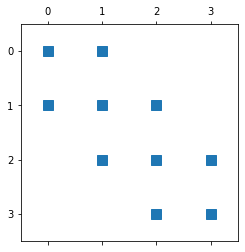

In [106]:
# matrice A_+
# N : nombre de sous-intervalles en temps
# M : nombre de sous-intervalles en espace
def A_plus(N,M):
    # pas d'espace et de temps
    hx = 1/M
    ht = T/N
    alpha = 0.5*ht/(hx**2)
    
    row = list()
    col = list()
    data = list()
    # premiere ligne
    # A_0,0
    row.append((0))
    col.append((0))
    data.append(1+2*alpha)
    # A_0,1
    row.append((0))
    col.append((1))
    data.append(-alpha)

    for i in range(1,M-2):
        # A_i,i = qque chose (exemple)
        row.append((i))
        col.append((i))
        data.append( 1+2*alpha )
    
        # A_i,i-1 = autre chose (exemple)
        row.append((i))
        col.append((i-1))
        data.append( -alpha )
    
        # A_i,i+1 = encore autre chose
        row.append((i))
        col.append((i+1))
        data.append( -alpha )

    # derniere ligne
    row.append((M-2))
    col.append((M-2))
    data.append(1+2*alpha)
    
    row.append((M-2))
    col.append((M-3))
    data.append((-alpha))
        
    # assemblage final
    row = np.array(row)
    col = np.array(col)
    data = np.array(data)
    A = (sparse.coo_matrix((data, (row, col)), shape=(M-1, M-1))).tocsr()
    
    
    return A

plt.spy(A_plus(5,5))

## Question 2 : Coder une fonction renvoyant le vecteur $F^{n+1}$ 

In [117]:
# vecteur F
# N,M : nombre d'intervalles de discretisation
# fonction second membre
# n : instant considéré (contributions en tn et t_{n-1})
def Fn(N,M,f,n):
    ht = T/N
    hx = 1/M
    tn = n*ht
    F = np.zeros(M-1)
    for j in range(M-1):
        xj = (j+1)*hx
        F[j] = 0.5*( f(tn-ht,xj) + f(tn,xj) )
    return F

## Question 3 : coder une fonction renvoyant la solution du schéma
On renverra la solution dans un tableau à double entrée (temps et espace).
Il faudra initialiser la solution avec la donnée initiale.
Puis, il faudra coder une boucle en temps. A chaque itération de cette boucle, il faudra renvoyer la solution du système linéaire 
$$
A_+ U^{n+1} = R ,
$$
avec $A_+$ définie précédemment et
$$
R = A_- U^n + h_t F^{n+1} .
$$

In [134]:
## calcul de la solution du schema
# N,M : nombre d'intervalles
# f : fonction second membre
# u_0 : donnee initiale
def CN_centre(N,M,f,u_0):
    ht = T/N
    hx = 1/M
    alpha = 0.5*ht/(hx**2)
    
    # initialisation de la solution
    u = np.zeros((N+1,M+1))
    for j in range(M-1):
        u[0,j] = u_0((j+1)*hx)
        
    # boucle en temps
    for n in range(N):
        ## calcul de la solution au temps t_{n+1}
        
        # calcul du second membre du systeme a resoudre
        RHS = ht * Fn(N,M,f,n+1)
        for j in range(M-1):
            RHS[j] += alpha*u[n,j] + (1-2*alpha)*u[n,j+1] + alpha*u[n,j+2]
        
        # resolution du systeme lineaire
        sol_lin = sparse.linalg.spsolve(A_plus(N,M), RHS)
        u[n+1,1:M] = sol_lin
        
    # fin
    return u

## Question 4 : afficher sur un même graphe la solution exacte et la solution numérique au temps final
On vérifiera la convergence de la méthode en raffinant les pas de temps et d'espace.

M= 20


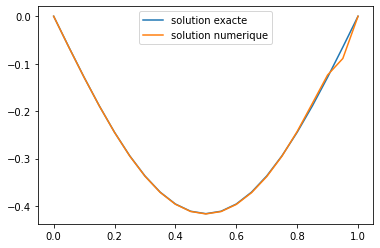

In [137]:
N = 20
M = 20
sol_num = CN_centre(N,M,f,u_0)[N,:]

X = np.linspace(0,1,M+1)

sol_ex = np.zeros(M+1)
for j in range(M+1):
    sol_ex[j] = u_ex(T,X[j])
    
plt.plot(X, sol_ex, label='solution exacte')
plt.plot(X, sol_num, label='solution numerique')

plt.legend()
plt.show()
